In [2]:
#need to run this twice due to bug in imported package

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import numpy as np
import seaborn as sns
import sys
from scipy import stats

sys.path.append("../")
from protocols import Helpers
from protocols.BuildCatalogue3 import BuildCatalogue

from protocols.Predict import predict

## Data imports

In [3]:
mutations = pd.read_csv("../../Data/cryptic2/tables/bdq_mutations.csv")
mutations["UNIQUEID"] = [i[:-19] for i in mutations.UNIQUEID]

genomes = pd.read_pickle("../../Data/cryptic2/tables/GENOMES.pkl.gz").reset_index(0)

phenotypes = pd.read_pickle(
    "../../Data/cryptic2/tables/PHENOTYPES.pkl.gz"
).reset_index()

sha_phenotypes = pd.read_pickle(
    "../../Data/tables/shaheed_tables/DST_MEASUREMENTS.pkl.gz"
).reset_index()
sha_phenotypes = sha_phenotypes[sha_phenotypes.DRUG == "BDQ"][
    ["UNIQUEID", "DRUG", "PHENOTYPE", "METHOD_MIC"]
]


## Data prep for catalogue building

In [4]:
#filter for high quality phenotypes
phenotypes = phenotypes[
    (phenotypes.DRUG == "BDQ") & (phenotypes.PHENOTYPE_QUALITY == "HIGH")
][["UNIQUEID", "DRUG", "BINARY_PHENOTYPE", "MIC"]].rename(
    columns={"BINARY_PHENOTYPE": "PHENOTYPE", "MIC": "METHOD_MIC"}
)
phenotypes = pd.concat([phenotypes, sha_phenotypes], ignore_index=True)
phenotypes = phenotypes[~phenotypes.METHOD_MIC.isna()]
phenotypes = phenotypes[~phenotypes.PHENOTYPE.isna()]


mutations_copy = mutations.copy()

#create column with gene_mutation entries
gene_muts = []
for i in mutations_copy.index:
    if mutations_copy["MUTATION"][i][0] == mutations_copy["MUTATION"][i][-1]:
        gene_muts.append(None)
    elif mutations_copy["IS_MINOR_ALLELE"][i]:
        gene_muts.append(
            mutations_copy["GENE"][i] + "_" + mutations_copy["MINOR_MUTATION"][i]
        )
    else:
        gene_muts.append(
            mutations_copy["GENE"][i] + "_" + mutations_copy["MUTATION"][i]
        )

mutations_copy["GENE_MUT"] = gene_muts
mutations = mutations_copy

#fil in FRS values of for non-minor alelles
mutations["FRS"] = [
    1 if ~mutations["IS_MINOR_ALLELE"][i] else mutations["FRS"][i]
    for i in mutations.index
]
mutations

,Unnamed: 0,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUT
0,1182,site.01.subj.DR0682.lab.DR0682.iso.1,mmpL5,D767N,gac,aac,NaN,NaN,767.0,True,NaN,NaN,767.0,N,1.0,False,NaN,1.0,mmpL5_D767N
1,1183,site.01.subj.DR0682.lab.DR0682.iso.1,mmpL5,T794I,acc,atc,NaN,NaN,794.0,True,NaN,NaN,794.0,I,1.0,False,NaN,1.0,mmpL5_T794I
2,1184,site.01.subj.DR0682.lab.DR0682.iso.1,mmpL5,I948V,att,gtt,NaN,NaN,948.0,True,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5_I948V
3,1583,site.01.subj.DR0674.lab.DR0674.iso.1,mmpL5,I948V,att,gtt,NaN,NaN,948.0,True,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5_I948V
4,3729,site.01.subj.DR0134.lab.DR0134.iso.1,mmpL5,T794I,acc,atc,NaN,NaN,794.0,True,NaN,NaN,794.0,I,1.0,False,NaN,1.0,mmpL5_T794I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95071,56524506,site.07.subj.FD_127_4342.lab.14.iso.1,mmpL5,Q440R,cag,cgg,NaN,NaN,440.0,True,NaN,NaN,440.0,R,1.0,False,NaN,1.0,mmpL5_Q440R
95072,56524507,site.07.subj.FD_127_4342.lab.14.iso.1,mmpL5,I948V,att,gtt,NaN,NaN,948.0,True,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5_I948V
95073,56524802,site.07.subj.B0F0114D-F7FB-45CF-9242-FBEF9B3FA...,mmpL5,V344L,gtc,ctc,NaN,NaN,344.0,True,NaN,NaN,344.0,L,1.0,False,NaN,1.0,mmpL5_V344L
95074,56524803,site.07.subj.B0F0114D-F7FB-45CF-9242-FBEF9B3FA...,mmpL5,I948V,att,gtt,NaN,NaN,948.0,True,NaN,NaN,948.0,V,1.0,False,NaN,1.0,mmpL5_I948V


In [5]:
#merge genomes and phenotypes tables
samples = pd.merge(genomes, phenotypes, on=["UNIQUEID"], how='inner')
samples = samples[["UNIQUEID", "DRUG", "PHENOTYPE", "METHOD_MIC"]]
samples

,UNIQUEID,DRUG,PHENOTYPE,METHOD_MIC
0,site.01.subj.DR0134.lab.DR0134.iso.1,BDQ,S,0.06
1,site.01.subj.DR0611.lab.DR0611.iso.1,BDQ,S,0.015
2,site.01.subj.DR0602.lab.DR0602.iso.1,BDQ,S,<=0.008
3,site.01.subj.DR0600.lab.DR0600.iso.1,BDQ,S,0.03
4,site.01.subj.DR0630.lab.DR0630.iso.1,BDQ,S,0.015
...,...,...,...,...
14330,site.14.subj.4314.lab.4314.iso.1,BDQ,S,0.03
14331,site.14.subj.1590.lab.1590.iso.1,BDQ,S,0.12
14332,site.14.subj.4200.lab.4200.iso.1,BDQ,S,0.06
14333,site.14.subj.4395.lab.4395.iso.1,BDQ,S,0.015


### Basic Numbers

In [6]:
all = pd.merge(mutations, phenotypes, on=['UNIQUEID'], how='inner')
all["IS_SYNONYMOUS"] = [
    True if i[0] == i[-1] else False for i in all.MUTATION
]
all = all[~all.IS_SYNONYMOUS]
all = all[~all.METHOD_MIC.isna()]
#General isolates
df = Helpers.RSIsolateTable(all, all.GENE.unique())
#minor allele isolates
df1 = Helpers.RSIsolateTable(all[all.FRS<0.9], all.GENE.unique())
#General variants
df2 = Helpers.RSVariantTable(all, all.GENE.unique())
df3 = Helpers.RSVariantTable(all[all.FRS<0.9], all.GENE.unique())
df = pd.concat([df, df1, df2, df3], axis=1)
df.columns = pd.MultiIndex.from_tuples(
    zip(['All', '', '', 'Minor alleles', '', '', 'All','','', 'Minor alleles', '', ''], 
        df.columns))
df

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   581  13641  14218           190  415   604  1788  28682  30470   
mmpL5   581  13636  14217             8  238   246  1083  27265  28348   
Rv0678  500    530   1030           178  130   308   666    634   1300   
pepQ     21    254    275            12   75    87    27    526    553   
mmpS5     2     95     97             1    5     6     3    103    106   
atpE      9     21     30             4    6    10     9    154    163   

       Minor alleles             
                   R    S Total  
Total            371  752  1123  
mmpL5             23  341   364  
Rv0678           324  208   532  
pepQ              18   88   106  
mmpS5              2    5     7  
atpE               4  110   114

## Build Catalogues

### Homogenous

In [7]:
catalogue_09 = BuildCatalogue(
    samples, mutations, 0.9
).return_catalogue()
catalogue_09 = (
    pd.DataFrame.from_dict(catalogue_09, orient="index")
    .reset_index(0)
    .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
)
catalogue_09

,GENE_MUT,phenotype
0,Rv0678_L40V,S
1,mmpL5_I948V,U


<Figure size 700x500 with 0 Axes>

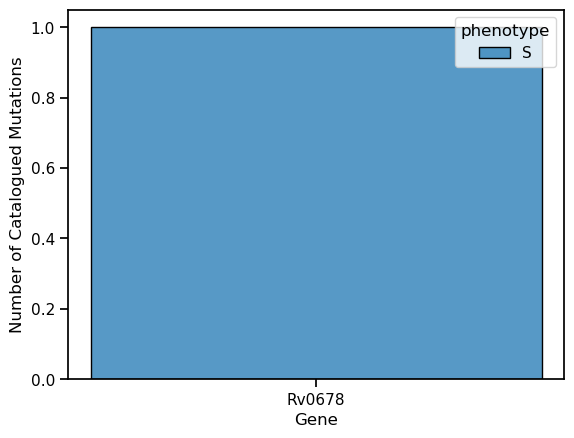

In [8]:
Helpers.plot_catalogue_counts(all, catalogue_09)

### Heterogenous

In [9]:
catalogue_01 = BuildCatalogue(
    samples, mutations, 0.1
).return_catalogue()
catalogue_01 = (
    pd.DataFrame.from_dict(catalogue_01, orient="index")
    .reset_index(0)
    .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
)
catalogue_01

,GENE_MUT,phenotype
0,mmpL5_I948V,S
1,mmpL5_L510P,S
2,mmpL5_A742A,S
3,pepQ_t-14c,S
4,mmpL5_V906A,S
...,...,...
653,Rv0678_L40M,R
654,mmpL5_L709I,R
655,Rv0678_325_ins_g,R
656,Rv0678_107_ins_g,R


<Figure size 700x500 with 0 Axes>

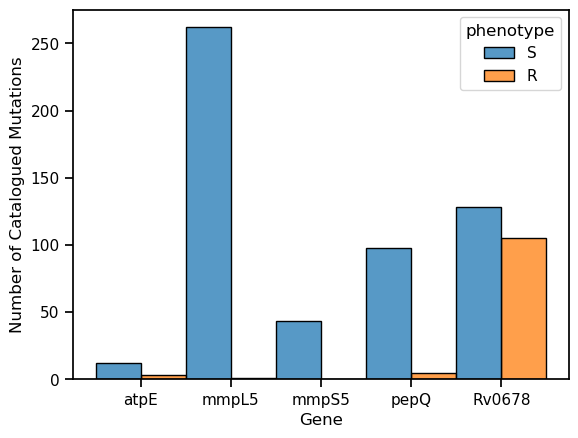

In [10]:
Helpers.plot_catalogue_counts(all, catalogue_01)

## Predict

### Homogenous

[[    0     0   577]
 [    0     1 13640]]
Catalogue coverage of isolates: 7.033338022225348e-05
Catalogue coverage of mutations: 0.0016025641025641025
Sensitivity: nan
Specificity: 1.0


/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/../protocols/Predict.py:80: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

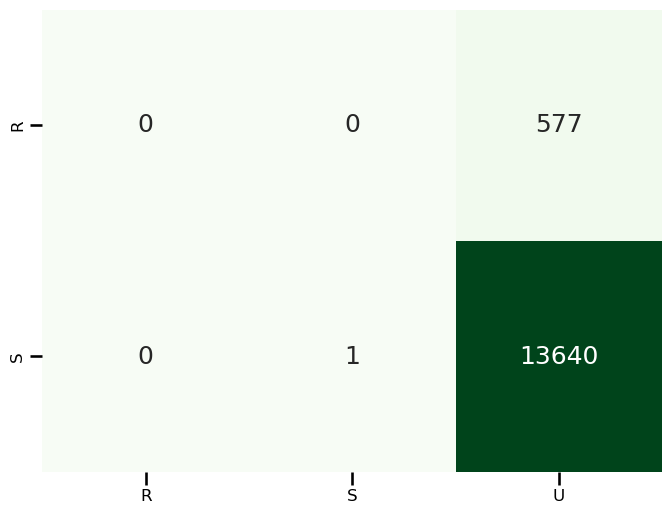

In [11]:
from protocols.Predict import predict

cm = predict(all, catalogue_09, Print=True)["cm"]
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])
plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(df_cm, annot=True, cbar=False, fmt="g", cmap="Greens")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

### Heterogenous

[[  388   159    30]
 [  133 13322   186]]
Catalogue coverage of isolates: 0.9848079898719933
Catalogue coverage of mutations: 0.5272435897435898
Sensitivity: 0.7093235831809872
Specificity: 0.990115198810851


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

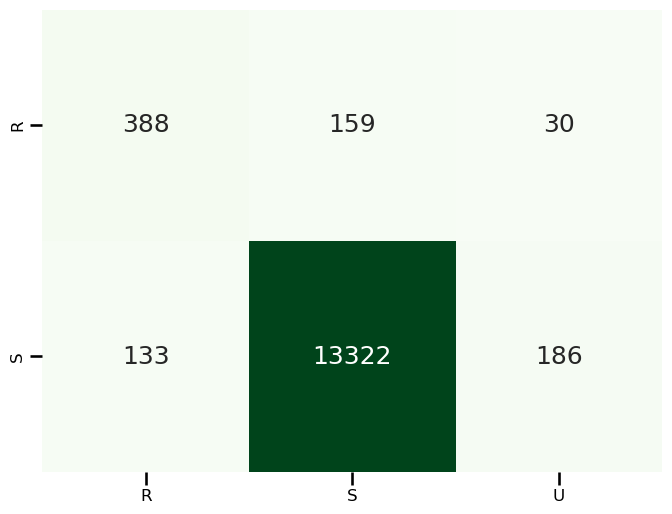

In [12]:
cm = predict(all, catalogue_01, Print=True)["cm"]
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])
plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(df_cm, annot=True, cbar=False, fmt="g", cmap="Greens")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Build Catalogue + predict with cross validation

In [34]:
samples = pd.merge(genomes, phenotypes, on=['UNIQUEID'], how='inner')
all = pd.merge(samples, mutations, on='UNIQUEID', how='left')

#### Homogenous

/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/../protocols/Predict.py:80: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/../protocols/Predict.py:81: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1][1] / (cm[1][1] + cm[1][0])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/../protocols/Predict.py:80: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/../protocols/Predict.py:81: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1][1] / (cm[1][1] + cm[1][0])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/.

isolate_cov (0.17961605584642232, 0.35923211169284464)
specificity (nan, nan)
sensitivity (nan, nan)


/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/../protocols/Predict.py:80: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/BDQ_analysis/notebooks/paper/../protocols/Predict.py:81: RuntimeWarning: invalid value encountered in scalar divide
  specificity = cm[1][1] / (cm[1][1] + cm[1][0])


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

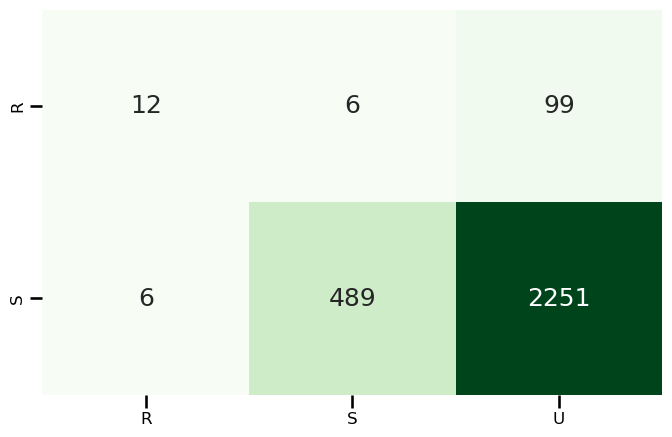

In [35]:
X = all.UNIQUEID.unique()
y = []
for i in X:
    y.append(all[all.UNIQUEID == i].PHENOTYPE.tolist()[0])


rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=7)
train_indices, test_indices = [], []
for i, (train_index, test_index) in enumerate(rs.split(X)):
    train_indices.append(train_index)
    test_indices.append(test_index)

ax_arr = []

isolate_cov, specificities, sensitivities, cms = [], [], [], []
for fold in range(len(train_indices)):
    train_ids, test_ids = [], []
    for i in train_indices[fold]:
        train_ids.append(X[i])
    for j in test_indices[fold]:
        test_ids.append(X[j])

    train_samples = samples[samples.UNIQUEID.isin(train_ids)]
    train_mutations = mutations[mutations.UNIQUEID.isin(train_ids)]
    test_df = all[all.UNIQUEID.isin(test_ids)]

    catalogue = BuildCatalogue(train_samples, train_mutations, 0.9).return_catalogue()
    catalogue = (
        pd.DataFrame.from_dict(catalogue, orient="index")
        .reset_index(0)
        .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
    )
    catalogue.index.rename("GENE_MUT", inplace=True)

    performance = predict(test_df, catalogue, Print=False)
    isolate_cov.append(performance["isolate_cov"])
    specificities.append(performance["specificity"])
    sensitivities.append(performance["sensitivity"])
    cms.append(performance["cm"])

isolate_cov = (np.mean(isolate_cov), np.std(isolate_cov))
specificity = (np.mean(specificities), np.std(specificities))
sensitivity = (np.mean(sensitivities), np.std(sensitivities))

print("isolate_cov", isolate_cov)
print("specificity", specificity)
print("sensitivity", sensitivity)


mean = np.mean(cms, axis=0)
std = np.std(cms, axis=0)

labels = [[], []]

for i in range(len(mean)):
    for j in range(len(mean[i])):
        labels[i].append("%s" % int(mean[i][j]))

df_cm = pd.DataFrame(mean, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm, annot=labels, cbar=False, cmap="Greens", fmt="")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#### Heterogenous

isolate_cov (0.8983595113438045, 0.0034931926012416754)
specificity (0.985503536895098, 0.0022038798735416684)
sensitivity (0.6956215321133539, 0.06228080363935468)


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

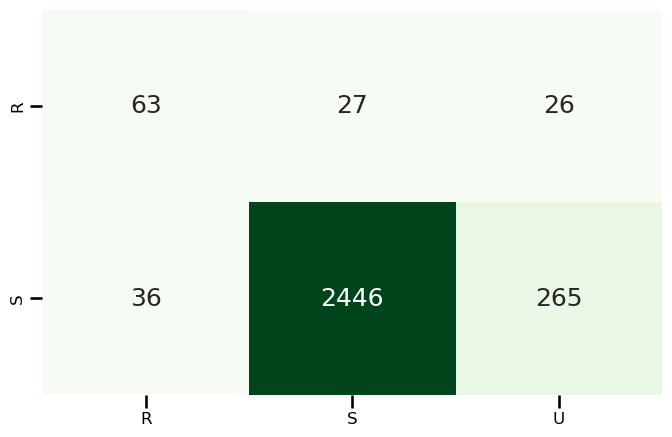

In [15]:
X = all.UNIQUEID.unique()
y = []
for i in X:
    y.append(all[all.UNIQUEID == i].PHENOTYPE.tolist()[0])


rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=7)
train_indices, test_indices = [], []
for i, (train_index, test_index) in enumerate(rs.split(X)):
    train_indices.append(train_index)
    test_indices.append(test_index)

ax_arr = []

isolate_cov, specificities, sensitivities, cms = [], [], [], []
for fold in range(len(train_indices)):
    train_ids, test_ids = [], []
    for i in train_indices[fold]:
        train_ids.append(X[i])
    for j in test_indices[fold]:
        test_ids.append(X[j])

    train_samples = samples[samples.UNIQUEID.isin(train_ids)]
    train_mutations = mutations[mutations.UNIQUEID.isin(train_ids)]
    test_df = all[all.UNIQUEID.isin(test_ids)]

    catalogue = BuildCatalogue(train_samples, train_mutations, 0.1).return_catalogue()
    catalogue = (
        pd.DataFrame.from_dict(catalogue, orient="index")
        .reset_index(0)
        .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
    )
    catalogue.index.rename("GENE_MUT", inplace=True)

    performance = predict(test_df, catalogue, Print=False)
    isolate_cov.append(performance["isolate_cov"])
    specificities.append(performance["specificity"])
    sensitivities.append(performance["sensitivity"])
    cms.append(performance["cm"])

isolate_cov = (np.mean(isolate_cov), np.std(isolate_cov))
specificity = (np.mean(specificities), np.std(specificities))
sensitivity = (np.mean(sensitivities), np.std(sensitivities))

print("isolate_cov", isolate_cov)
print("specificity", specificity)
print("sensitivity", sensitivity)


mean = np.mean(cms, axis=0)
std = np.std(cms, axis=0)

labels = [[], []]

for i in range(len(mean)):
    for j in range(len(mean[i])):
        labels[i].append("%s" % int(mean[i][j]))


df_cm = pd.DataFrame(mean, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm, annot=labels, cbar=False, cmap="Greens", fmt="")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Remove mmpL5 from dataset and rebuild and predict

In [17]:
all_no_mmpL5 = all[all.GENE != "mmpL5"]
mutations_no_mmpL5 = mutations[mutations.GENE!='mmpL5']

### Build and predict on entire dataset

#### Homogenous

In [18]:
catalogue_09 = BuildCatalogue(samples, mutations_no_mmpL5, 0.9).return_catalogue()
catalogue_09 = (
    pd.DataFrame.from_dict(catalogue_09, orient="index")
    .reset_index(0)
    .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
)
catalogue_09

,GENE_MUT,phenotype
0,Rv0678_c-11a,S
1,pepQ_V238M,S
2,Rv0678_R50Q,S
3,Rv0678_E55D,S
4,Rv0678_142_ins_t,S
...,...,...
319,atpE_E61D,U
320,Rv0678_S2I,U
321,Rv0678_M139I,U
322,Rv0678_N98D,U


[[390  60  68]
 [148 571 404]]
Catalogue coverage of isolates: 0.712370505789153
Catalogue coverage of mutations: 0.375
Sensitivity: 0.8666666666666667
Specificity: 0.7941585535465925


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

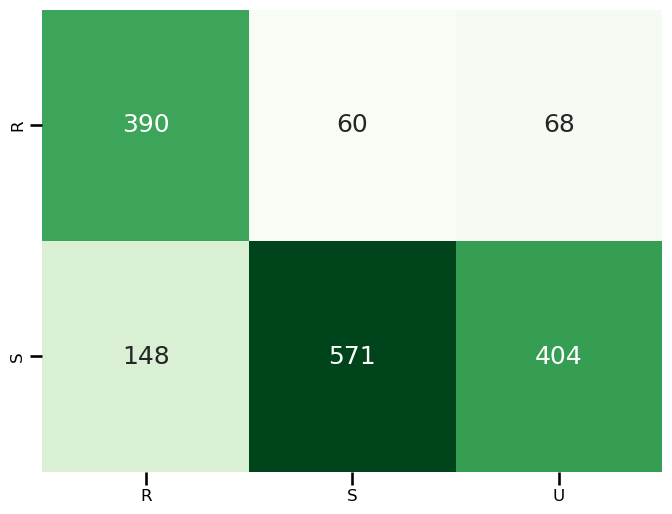

In [19]:
cm = predict(all_no_mmpL5, catalogue_09, Print=True)["cm"]
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(df_cm, annot=True, cbar=False, fmt="g", cmap="Greens")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#### Heterogenous

In [20]:
catalogue_01 = BuildCatalogue(samples, mutations_no_mmpL5, 0.1).return_catalogue()
catalogue_01 = (
    pd.DataFrame.from_dict(catalogue_01, orient="index")
    .reset_index(0)
    .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
)
catalogue_01

,GENE_MUT,phenotype
0,pepQ_V238M,S
1,Rv0678_R50Q,S
2,Rv0678_E55D,S
3,Rv0678_142_ins_t,S
4,Rv0678_G24S,S
...,...,...
419,Rv0678_S68N,R
420,Rv0678_L40M,R
421,Rv0678_325_ins_g,R
422,Rv0678_107_ins_g,R


[[421  70  27]
 [146 617 360]]
Catalogue coverage of isolates: 0.7641681901279708
Catalogue coverage of mutations: 0.49074074074074076
Sensitivity: 0.8574338085539714
Specificity: 0.8086500655307994


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

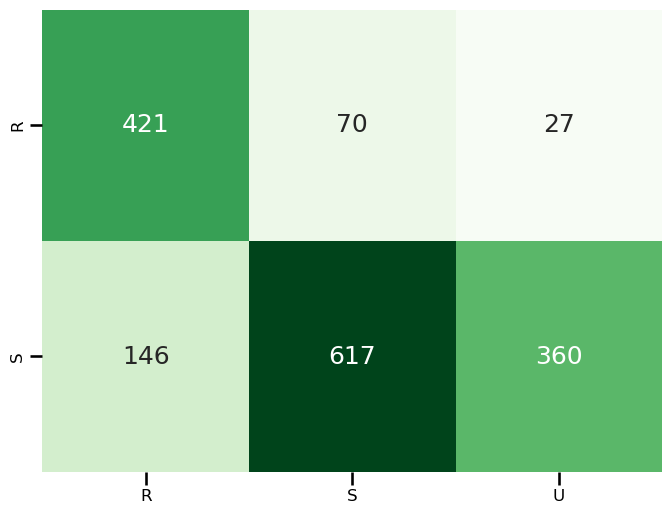

In [21]:
cm = predict(all_no_mmpL5, catalogue_01, Print=True)["cm"]
df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(df_cm, annot=True, cbar=False, fmt="g", cmap="Greens")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

### Build and predict with cross validation

#### Homogenous

isolate_cov (0.5173252279635259, 0.031435096592943225)
specificity (0.6934278003078422, 0.03389230105056328)
sensitivity (0.8621113805684821, 0.02621879170546563)


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

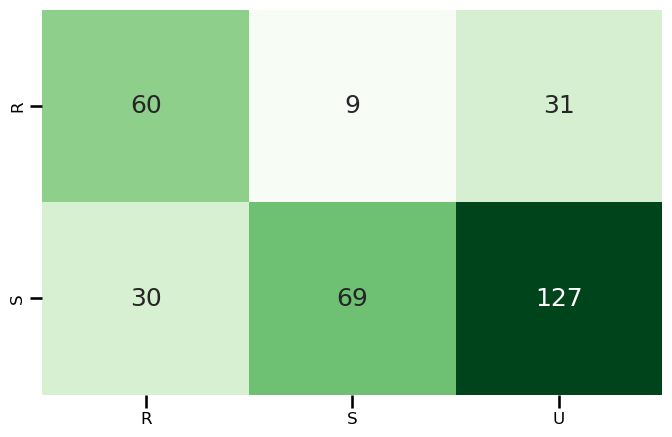

In [32]:
X = all_no_mmpL5.UNIQUEID.unique()
y = []
for i in X:
    y.append(all_no_mmpL5[all_no_mmpL5.UNIQUEID == i].PHENOTYPE.tolist()[0])


rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=7)
train_indices, test_indices = [], []
for i, (train_index, test_index) in enumerate(rs.split(X)):
    train_indices.append(train_index)
    test_indices.append(test_index)

ax_arr = []

isolate_cov, specificities, sensitivities, cms = [], [], [], []
for fold in range(len(train_indices)):
    train_ids, test_ids = [], []
    for i in train_indices[fold]:
        train_ids.append(X[i])
    for j in test_indices[fold]:
        test_ids.append(X[j])

    train_samples = samples[samples.UNIQUEID.isin(train_ids)]
    train_mutations = mutations_no_mmpL5[mutations_no_mmpL5.UNIQUEID.isin(train_ids)]
    test_df = all_no_mmpL5[all_no_mmpL5.UNIQUEID.isin(test_ids)]

    catalogue = BuildCatalogue(train_samples, train_mutations, 0.9).return_catalogue()
    catalogue = (
        pd.DataFrame.from_dict(catalogue, orient="index")
        .reset_index(0)
        .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
    )
    catalogue.index.rename("GENE_MUT", inplace=True)

    performance = predict(test_df, catalogue, Print=False)
    isolate_cov.append(performance["isolate_cov"])
    specificities.append(performance["specificity"])
    sensitivities.append(performance["sensitivity"])
    cms.append(performance["cm"])

isolate_cov = (np.mean(isolate_cov), np.std(isolate_cov))
specificity = (np.mean(specificities), np.std(specificities))
sensitivity = (np.mean(sensitivities), np.std(sensitivities))

print("isolate_cov", isolate_cov)
print("specificity", specificity)
print("sensitivity", sensitivity)


mean = np.mean(cms, axis=0)
std = np.std(cms, axis=0)

labels = [[], []]

for i in range(len(mean)):
    for j in range(len(mean[i])):
        labels[i].append("%s" % int(mean[i][j]))


df_cm = pd.DataFrame(mean, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm, annot=labels, cbar=False, cmap="Greens", fmt="")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#### Heterogenous

isolate_cov (0.5525835866261398, 0.01351131353853671)
specificity (0.6684290987447243, 0.02809917261107198)
sensitivity (0.804390188330372, 0.021557393909319877)


(array([0.5, 1.5]), [Text(0, 0.5, 'R'), Text(0, 1.5, 'S')])

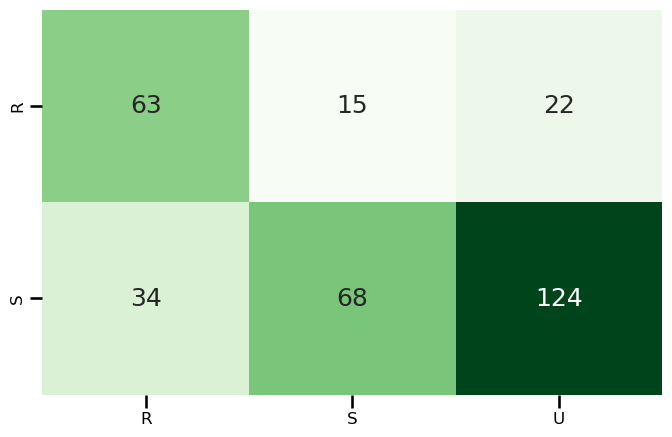

In [33]:
X = all_no_mmpL5.UNIQUEID.unique()
y = []
for i in X:
    y.append(all_no_mmpL5[all_no_mmpL5.UNIQUEID == i].PHENOTYPE.tolist()[0])


rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=7)
train_indices, test_indices = [], []
for i, (train_index, test_index) in enumerate(rs.split(X)):
    train_indices.append(train_index)
    test_indices.append(test_index)

ax_arr = []

isolate_cov, specificities, sensitivities, cms = [], [], [], []
for fold in range(len(train_indices)):
    train_ids, test_ids = [], []
    for i in train_indices[fold]:
        train_ids.append(X[i])
    for j in test_indices[fold]:
        test_ids.append(X[j])

    train_samples = samples[samples.UNIQUEID.isin(train_ids)]
    train_mutations = mutations_no_mmpL5[mutations_no_mmpL5.UNIQUEID.isin(train_ids)]
    test_df = all_no_mmpL5[all_no_mmpL5.UNIQUEID.isin(test_ids)]

    catalogue = BuildCatalogue(train_samples, train_mutations, 0.1).return_catalogue()
    catalogue = (
        pd.DataFrame.from_dict(catalogue, orient="index")
        .reset_index(0)
        .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
    )
    catalogue.index.rename("GENE_MUT", inplace=True)

    performance = predict(test_df, catalogue, Print=False)
    isolate_cov.append(performance["isolate_cov"])
    specificities.append(performance["specificity"])
    sensitivities.append(performance["sensitivity"])
    cms.append(performance["cm"])

isolate_cov = (np.mean(isolate_cov), np.std(isolate_cov))
specificity = (np.mean(specificities), np.std(specificities))
sensitivity = (np.mean(sensitivities), np.std(sensitivities))

print("isolate_cov", isolate_cov)
print("specificity", specificity)
print("sensitivity", sensitivity)


mean = np.mean(cms, axis=0)
std = np.std(cms, axis=0)

labels = [[], []]

for i in range(len(mean)):
    for j in range(len(mean[i])):
        labels[i].append("%s" % int(mean[i][j]))


df_cm = pd.DataFrame(mean, index=["R", "S"], columns=["R", "S", "U"])
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm, annot=labels, cbar=False, cmap="Greens", fmt="")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [55]:
sns.set_context("notebook")


samples = pd.merge(genomes, phenotypes, on=["UNIQUEID"], how="inner")
all = pd.merge(samples, mutations, on="UNIQUEID", how="left")
all['MIC_FLOAT'] = Helpers.mic_to_float(list(all['METHOD_MIC']))

catalogue_01 = BuildCatalogue(samples, mutations, 0.1).return_catalogue()
catalogue_01 = (
    pd.DataFrame.from_dict(catalogue_01, orient="index")
    .reset_index(0)
    .rename(columns={"index": "GENE_MUT", 0: "phenotype"})
)

R_muts = catalogue_01[catalogue_01.phenotype == "R"].GENE_MUT.tolist()
# should only look at samples with a single R mutation (can have multipled S) that has been catalogued as R
ids, solo_Rs = all.UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df[(df.GENE_MUT.isin(R_muts))]) == 1:
        solo_Rs.append(i)

plt.figure(figsize=(8, 7))
df = pd.DataFrame.from_dict(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            str(i)
            for i in np.log2(
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)
df["binned_FRS"] = [str(round(i, 1)) for i in df.FRS.tolist()]
df["binned_MIC"] = [str(i) for i in df.MIC]
df

,GENE_MUT,FRS,MIC,binned_FRS,binned_MIC
0,Rv0678_V120M,0.133,-5.058893689053568,0.1,-5.058893689053568
1,Rv0678_141_ins_c,0.596,-4.058893689053568,0.6,-4.058893689053568
2,Rv0678_138_ins_g,0.600,-1.0,0.6,-1.0
3,Rv0678_138_ins_g,0.462,-1.0,0.5,-1.0
4,Rv0678_141_ins_c,1.000,-3.0588936890535687,1.0,-3.0588936890535687
...,...,...,...,...,...
449,Rv0678_L40F,1.000,-1.0,1.0,-1.0
450,mmpL5_L709I,1.000,-1.0,1.0,-1.0
451,Rv0678_325_ins_g,1.000,0.0,1.0,0.0
452,Rv0678_138_ins_g,1.000,-2.0,1.0,-2.0


<Figure size 800x700 with 0 Axes>

In [40]:
all.columns

Index(['UNIQUEID', 'SITEID', 'SUBJID', 'LABID', 'ISOLATENO', 'SEQREPS',
       'CLOCKWORK_VERSION', 'FTP_PATH', 'FTP_FILENAME_VCF', 'TREE_PATH',
       'TREE_FILENAME_VCF', 'WGS_PREDICTION_STRING', 'DRUG', 'PHENOTYPE',
       'METHOD_MIC', 'Unnamed: 0', 'GENE', 'MUTATION', 'REF', 'ALT',
       'NUCLEOTIDE_NUMBER', 'NUCLEOTIDE_INDEX', 'GENE_POSITION',
       'CODES_PROTEIN', 'INDEL_LENGTH', 'INDEL_NUCLEOTIDES',
       'AMINO_ACID_NUMBER', 'AMINO_ACID_SEQUENCE', 'NUMBER_NUCLEOTIDE_CHANGES',
       'IS_MINOR_ALLELE', 'MINOR_MUTATION', 'FRS', 'GENE_MUT'],
      dtype='object')

In [56]:
df["binned_FRS"] = [str(round(i, 1)) for i in df.FRS.tolist()]
df["binned_MIC"] = [str(i) for i in df.MIC]
df["Mutation"] = [
    i if i in ["Rv0678_192_ins_g", "Rv0678_141_ins_c"] else "Rv0678"
    for i in df["GENE_MUT"]
]
df = df.sort_values(by=["Mutation"])

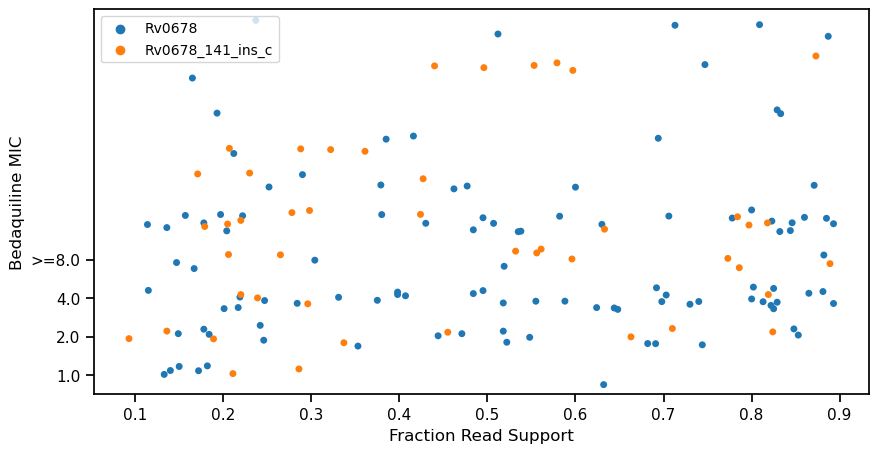

In [57]:
plt.figure(figsize=(10, 5))
ax = sns.stripplot(data=df[df.FRS < 0.9], x="FRS", y="MIC", jitter=0.3, hue="Mutation")
ax.invert_yaxis()
# ax = sns.scatterplot(x=all_bdq_sha[(all_bdq_sha.UNIQUEID.isin(solo_Rs))&(all_bdq_sha.GENE_MUT.isin(R_muts))].FRS, y=np.log2((all_bdq_sha[(all_bdq_sha.UNIQUEID.isin(solo_Rs))&(all_bdq_sha.GENE_MUT.isin(R_muts))].MIC_FLOAT)))
# ax = sns.scatterplot(x=all_bdq_sha[(all_bdq_sha.UNIQUEID.isin(solo_Rs))&(all_bdq_sha.GENE_MUT.isin(R_muts))].FRS, y=np.log((all_bdq_sha[(all_bdq_sha.UNIQUEID.isin(solo_Rs))&(all_bdq_sha.GENE_MUT.isin(R_muts))].MIC_FLOAT)))
ax.set(xlabel="Fraction Read Support", ylabel="Bedaquiline MIC")
ax.set_yticks([0, 1, 2, 3], labels=[1.0, 2.0, 4.0, ">=8.0"])
plt.legend(fontsize="small")
plt.show()